<a href="https://colab.research.google.com/github/tomafischer/ai_geeks/blob/main/deeplearning/Intro_to_Deep_Learning_30_minutes_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Deep Learning - a practical approach with Pytorch
**Author**: Tom Fischer 

------
**Description**: 
Deep learning intro in less than 30 minutes with Pytorch

We will use a Artifical Neural Network (ANN) for a regression of MPG forcasting based on car features like engine size, horse power, cylinders, etc.

-----------
**Resources:**
- [Pytorch](https://pytorch.org/)
- [Udemy class A deep understanding of deep learning (with Python intro)](https://www.udemy.com/course/deeplearning_x/) 
- [DataCamp - Introduction to Deep Learning with PyTorch](https://www.datacamp.com/courses/introduction-to-deep-learning-with-pytorch)

---------
**Table of Content**
1. Data Prep: Getting data, data normalization, cross-validation, preping for torch
2. Craeting Deep Learning Network
3. Train Network
4. Model evaluations => overfitting, epoch analysis
5. Tuning Learning Curves => overfitting, adjusting learning curve, epoch tuning

--------
**Not part of this class:**
6. Regularization: Dropouts, L1/L2 weight regularization, batch training
7. Metaparameter optimazation: activation functions, optimizers, batch normalizations

## 1) Data, Data, Data
We will use the Seaborn mpg.csv dataset to predict the mpg from car features


In [165]:
# the usual math and data packages
import numpy as np
import pandas as pd
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
# model evaluation, z-score
import scipy.stats as stats
# data prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# unit testing
import unittest

In [24]:
import seaborn as sns
cars_pd= sns.load_dataset('mpg')
#dropping na values
cars_pd = cars_pd.dropna()
print(f"Length for car data: {len(cars_pd)}\n ")
cars_pd.head()
# some plots to shwo the data


Length for car data: 392
 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [25]:
# Statics on the numerical values
cars_pd.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


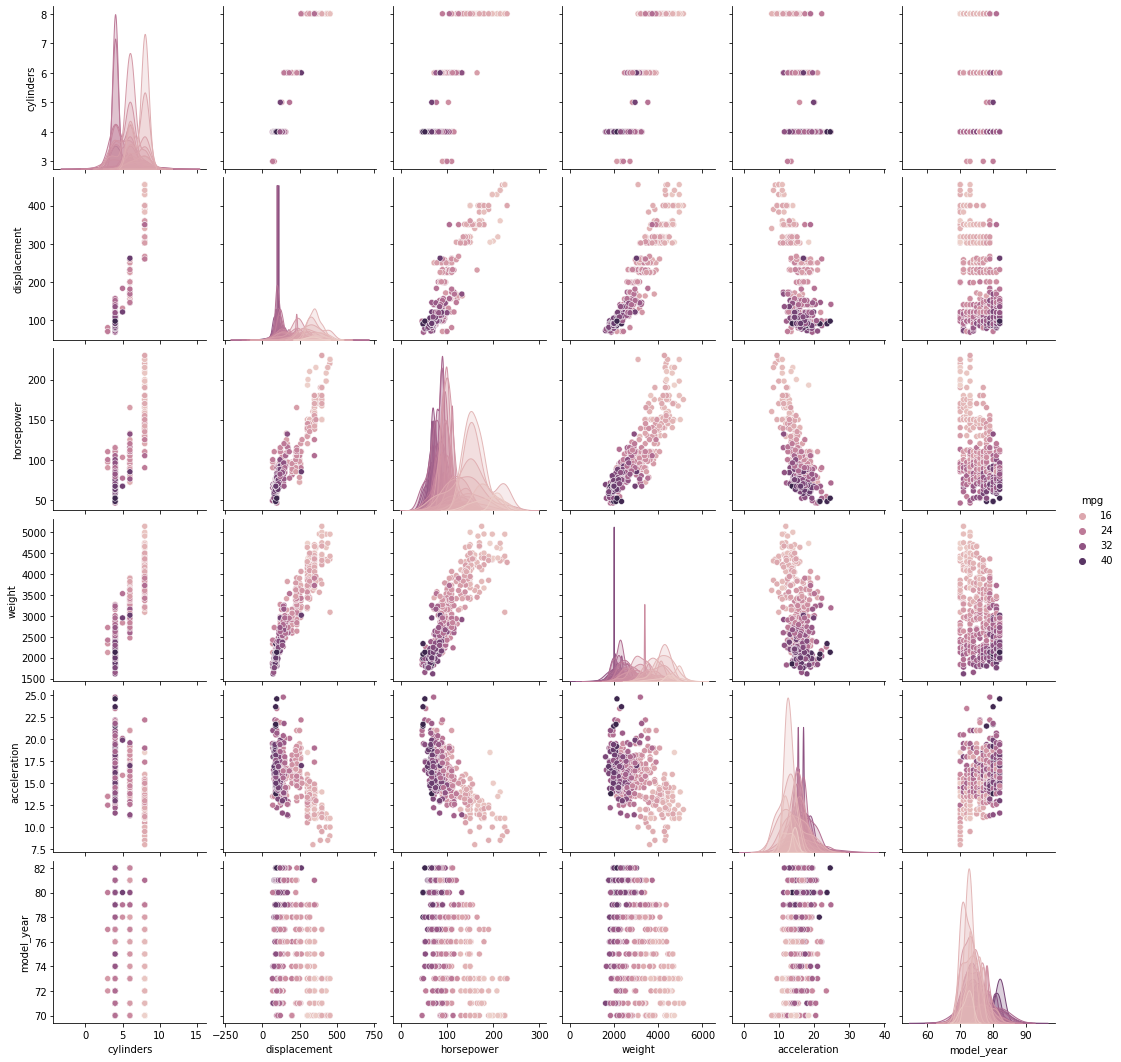

In [26]:
# Correlation Plots
sns.pairplot(cars_pd, hue='mpg')
plt.show()

In [168]:
#####
#    Defining features
#####
feature_labels = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
pred_label =['mpg']

####
#.   Scale data
####
# getting numpy array of data
cars_x_np = cars_pd[feature_labels].values
cars_y_np = cars_pd[pred_label].values
# scale the data
scaler_x = preprocessing.StandardScaler()
scaler_y =  preprocessing.StandardScaler()
cars_x_np = scaler_x.fit_transform(cars_x_np)
cars_y_np = scaler_y.fit_transform(cars_y_np)

#####
#    Create Tensors
#####
cars_x = torch.tensor(cars_x_np).float()
cars_y = torch.tensor(cars_y_np).float()

######
#.    Creating train and test set - Cross validation
######
train_x, test_x, train_y, test_y  = train_test_split(cars_x, cars_y, train_size=0.8)

In [28]:
cars_pd

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


In [169]:
print(f"Cars_x.shape:  {cars_x.shape}")
print(f"Cars_y.shape:  {cars_y.shape}")
print("Train data:")
print(f"train_x.shape: {train_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"Test data:")
print(f"test_x.shape:  {test_x.shape}")
print(f"test_y.shape:  {test_y.shape}")

Cars_x.shape:  torch.Size([392, 6])
Cars_y.shape:  torch.Size([392, 1])
Train data:
train_x.shape: torch.Size([313, 6])
train_y.shape: torch.Size([313, 1])
Test data:
test_x.shape:  torch.Size([79, 6])
test_y.shape:  torch.Size([79, 1])


In [170]:
# first few records
test_x[0:4,:]

tensor([[-0.8640, -0.9895, -0.9487, -1.1701,  0.1665,  1.3646],
        [-0.8640, -0.8364, -0.4804, -0.6054, -0.0150,  0.0055],
        [ 0.3100,  0.0439, -0.3764, -0.3885, -0.1965, -1.6253],
        [-0.8640, -0.7024, -0.1683, -0.0384, -0.3779, -0.2663]])

In [171]:
test_y[0:4,:]

tensor([[ 1.3668],
        [ 0.5842],
        [-0.3138],
        [-0.1855]])

## 2) Creating Deep Learning Model

### Neural Network Layout and Math for one Neuron
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_network.png?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_networks_neuron_overview.jpeg?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>


### What do we need:
- **Deep Learning Model** (see above)
- **Loss Function**: Mesaure accuracy of model  => Root Square Mean RMS
- **Optimzer**: To handle the optimization for training
- **Forward progagation**: Compute output based on input for predicting a dataset 
- **Backwards propagation** (backprop): Adjust the weights based on loss/cost
- **Learning Rate**: Amount of adjustments during the backprop
- **Epochs**: Amount of iterations for the learning process. Each epoch uses the full dataset with full backprop 

In [205]:
class CarsNeuralNetwork(nn.Module):
  def __init__(self, lr= 0.01):
    super().__init__()

    # Model definition
    self.model =  nn.Sequential(
      nn.Linear(6, 9),      ## input layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(9,12),      ## first hidden linear layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(12,6),      ## second hidden linear layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(6,1)        ## output layer
    )
  
    # learning rate
    self.learning_rate = lr
  
    # loss function
    self.loss_fn = nn.MSELoss() # Mean Square Error

    #optimizer - used for backprop
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr= self.learning_rate)
  
  def forward(self,x):
    """
    Forward progagation: 
    input: records to be passed through the model. 
      Note: the record size must match the model size (in our case 6)
    output: predicted values  
    """
    pred = self.model(x)
    return pred

  def train_model(self, x, y):
    """
    Training method with backprogation
    input: x, y for training
    output: loss from forward pass 
    """
    #forward pass
    pred = self.model(x)

    #compute loss
    loss = self.loss_fn(pred, y)

    #backprop
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss

In [206]:
cars_ann = CarsNeuralNetwork(lr=0.01)
print(f"Model definition:\n{cars_ann.model}")

Model definition:
Sequential(
  (0): Linear(in_features=6, out_features=9, bias=True)
  (1): ReLU()
  (2): Linear(in_features=9, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)


In [159]:
pred = cars_ann(train_x)
loss = cars_ann.loss_fn(pred,train_y)
cars_ann.optimizer.zero_grad()
loss.backward()
cars_ann.optimizer.step()

In [121]:
loss

tensor(6747.9473, grad_fn=<MseLossBackward>)

## 3) Train model

In [188]:
def train_epochs(model, train_x, train_y, test_x, test_y, epochs = 100, verbose = True):
  losses_train = []
  losses_test = []

  for epoch in range(epochs):

    # run the training cycle 
    #   - with backprob
    loss_train = model.train_model(train_x,train_y)
    # append the train loss
    losses_train.append(loss_train.item())

    # evaluate the model on the test data
    # -> run only forward with test data
    with torch.no_grad():
      pred_test = model(test_x)
      loss_test = model.loss_fn(pred_test, test_y)
      # append the test loss
      losses_test.append(loss_test.item())
    
    # intermediate print out
    if verbose and epoch % 20 == 0:
      print(f"Epoch [{epoch+1}/{epochs}] - Loss Train: {loss_train} - Loss Test: {loss_test} ")
  return losses_train, losses_test
 




In [257]:
########
#        The actual training is finally happening!!!!
########

cars_ann = CarsNeuralNetwork(lr=0.01)
losses_train, losses_test = train_epochs(model= cars_ann, train_x= train_x, train_y= train_y, 
                      test_x= test_x, test_y= test_y, epochs = 500)

Epoch [1/500] - Loss Train: 1.0802431106567383 - Loss Test: 1.2199633121490479 
Epoch [21/500] - Loss Train: 0.9924498796463013 - Loss Test: 1.0977455377578735 
Epoch [41/500] - Loss Train: 0.9257599711418152 - Loss Test: 1.0063494443893433 
Epoch [61/500] - Loss Train: 0.857743501663208 - Loss Test: 0.9191222190856934 
Epoch [81/500] - Loss Train: 0.7828323245048523 - Loss Test: 0.8305307626724243 
Epoch [101/500] - Loss Train: 0.6917884945869446 - Loss Test: 0.7265374660491943 
Epoch [121/500] - Loss Train: 0.5965777635574341 - Loss Test: 0.6245395541191101 
Epoch [141/500] - Loss Train: 0.519923985004425 - Loss Test: 0.5505189895629883 
Epoch [161/500] - Loss Train: 0.46873775124549866 - Loss Test: 0.5047126412391663 
Epoch [181/500] - Loss Train: 0.43373391032218933 - Loss Test: 0.4738021492958069 
Epoch [201/500] - Loss Train: 0.4069278836250305 - Loss Test: 0.4491247832775116 
Epoch [221/500] - Loss Train: 0.3835521936416626 - Loss Test: 0.4261692464351654 
Epoch [241/500] - Loss

## 4) Evaluate Model
based on Learning rate 

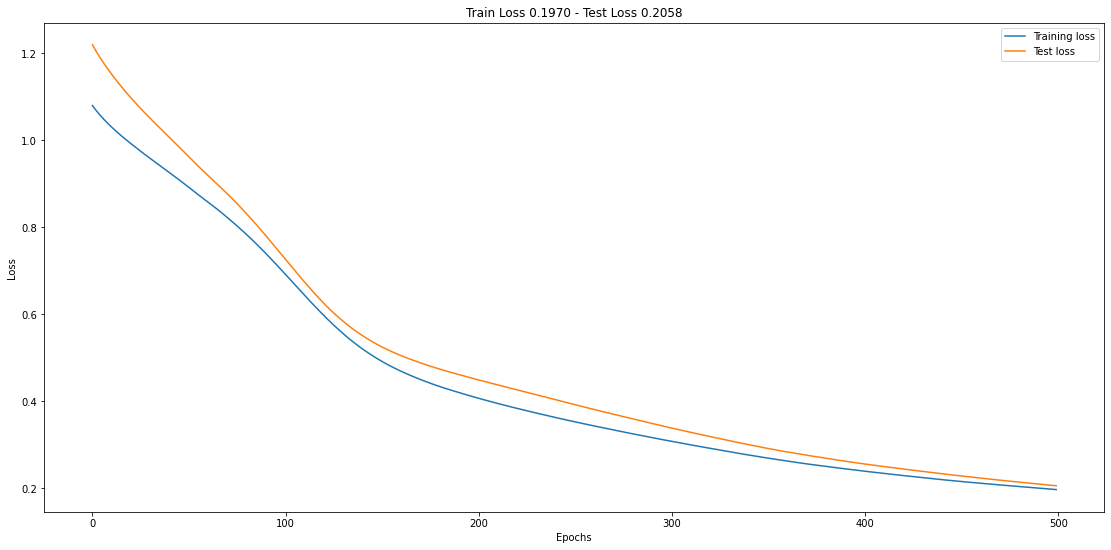

In [258]:
######
#      Plot Losses
#      for Classifications we would add accuracy and the Confusion Matrix
######
fig, axs = plt.subplots(1,1, figsize =(19,9))
ax = axs
ax.plot(losses_train, label="Training loss")
ax.plot()
ax.plot(losses_test, label= "Test loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(f"Train Loss {losses_train[-1]:.4f} - Test Loss {losses_test[-1]:.4f}")
ax.legend()
plt.show()

## 5) Investigating/Tuning Learning rate
We look at the effects of the learning rate and compare the learning rate curves 

**Question to think about:**
- How does affect overfitting?

In [250]:
# Meta experiment
# creating learning rates
learning_rates = np.linspace(0.001,0.1, 15)
#print(f"Learning rates: {learning_rates}")

losses_train_all =[]
losses_test_all =[]
for lr in learning_rates:
  #print(f"lr: {lr}")
  cars_ann = CarsNeuralNetwork(lr=lr)
  losses_train, losses_test = train_epochs(model= cars_ann, train_x= train_x, train_y= train_y, 
                      test_x= test_x, test_y= test_y, epochs = 2000, verbose= False)
  losses_train_all.append(losses_train)
  losses_test_all.append(losses_test) 
  print(f"Learning rate {lr:.4f} - loss training {losses_train[-1]} - loss testing {losses_test[-1]}")



Learning rate 0.0010 - loss training 0.3624245822429657 - loss testing 0.4252763092517853
Learning rate 0.0081 - loss training 0.11490537226200104 - loss testing 0.12185400724411011
Learning rate 0.0151 - loss training 0.10914897918701172 - loss testing 0.127970352768898
Learning rate 0.0222 - loss training 0.11467277258634567 - loss testing 0.13707348704338074
Learning rate 0.0293 - loss training 0.10667236894369125 - loss testing 0.13109873235225677
Learning rate 0.0364 - loss training 0.10035580396652222 - loss testing 0.11956769227981567
Learning rate 0.0434 - loss training 0.09562747925519943 - loss testing 0.1251981556415558
Learning rate 0.0505 - loss training 0.09841662645339966 - loss testing 0.11829107254743576
Learning rate 0.0576 - loss training 0.09564366936683655 - loss testing 0.11080451309680939
Learning rate 0.0646 - loss training 0.10783044993877411 - loss testing 0.12285367399454117
Learning rate 0.0717 - loss training 0.09185785800218582 - loss testing 0.12611319124

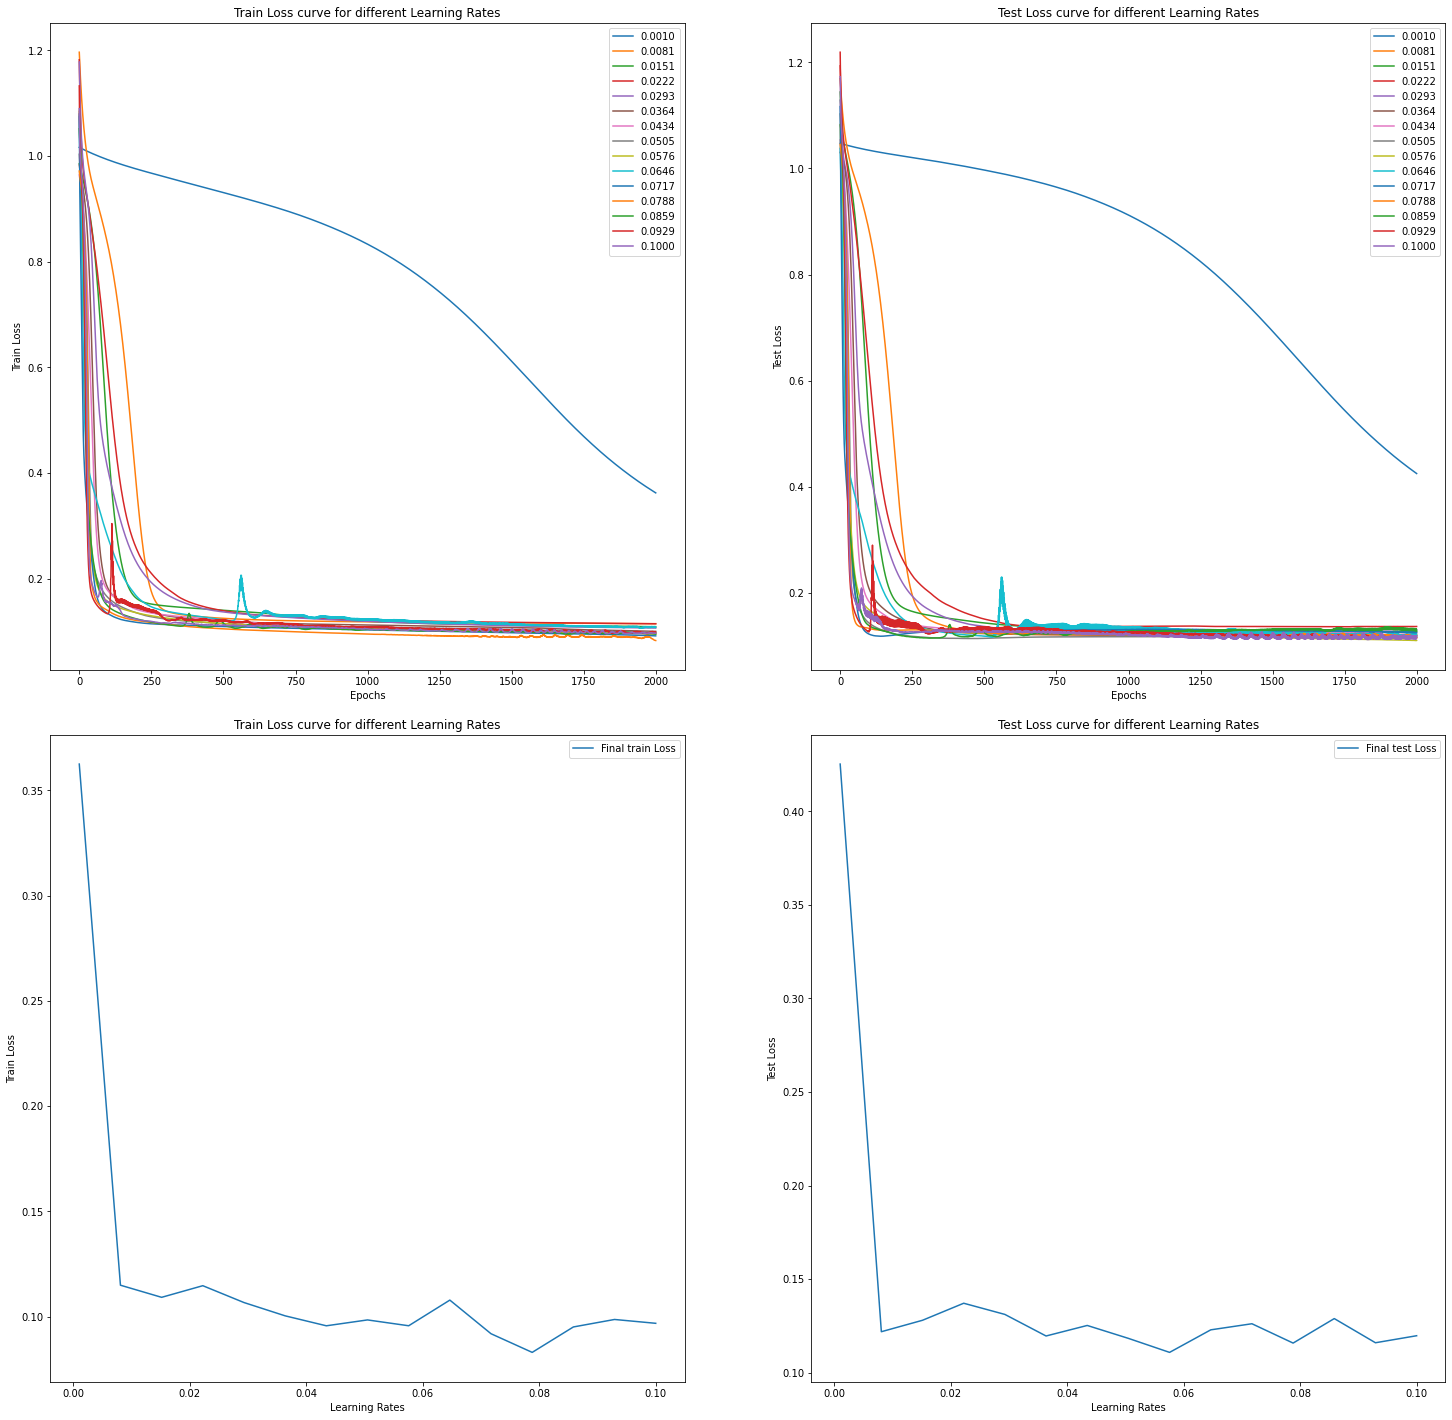

In [251]:
# charting
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(25,25))
# plotting learning curves
ax = ax1[0]
for lr, curve in zip(learning_rates,losses_train_all ):
  ax.plot(curve, label=f"{lr:.4f}")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
ax.set_title("Train Loss curve for different Learning Rates")

ax = ax1[1]
for lr, curve in zip(learning_rates,losses_test_all ):
  ax.plot(curve, label=f"{lr:.4f}")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Test Loss")
ax.set_title("Test Loss curve for different Learning Rates")

# plotting final Losses
ax = ax2[0]
losses_train_all_final = np.array(losses_train_all)[:,-1]
ax.plot(learning_rates, losses_train_all_final, label = "Final train Loss")
ax.legend()
ax.set_xlabel("Learning Rates")
ax.set_ylabel("Train Loss")
ax.set_title("Train Loss curve for different Learning Rates")



ax = ax2[1]
losses_test_all_final = np.array(losses_test_all)[:,-1]
ax.plot(learning_rates, losses_test_all_final, label = "Final test Loss")
ax.legend()
ax.set_xlabel("Learning Rates")
ax.set_ylabel("Test Loss")
ax.set_title("Test Loss curve for different Learning Rates")


plt.subplots_adjust(hspace=0.1)
plt.show()